<a href="https://colab.research.google.com/github/LyaSofya/Adversarial-ML/blob/main/FGSM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import requests
from tensorflow.keras.applications.mobilenet_v2 import decode_predictions

In [ ]:
# Set the size of the figures that matplotlib will create
mpl.rcParams['figure.figsize'] = (8, 8)
# Enable grid on the figures
mpl.rcParams['axes.grid'] = False

In [ ]:
# Load the MobileNetV2 model, pretrained on ImageNet
pretrained_model = tf.keras.applications.MobileNetV2(include_top=True, weights='imagenet')
# We won't be training the model, so we set its trainable flag to False
pretrained_model.trainable = False

In [ ]:
# Helper function to convert the output probabilities into human-readable labels
decode_predictions = tf.keras.applications.mobilenet_v2.decode_predictions
decode_predictions

<function keras.src.applications.mobilenet_v2.decode_predictions(preds, top=5)>

In [ ]:
# Helper function to preprocess the image so that it can be inputted in MobileNetV2
def preprocess(image):
  image = tf.cast(image, tf.float32)  # Cast the image tensor to float
  image = tf.image.resize(image, (224, 224))  # Resize the image to 224x224 pixels
  image = tf.keras.applications.mobilenet_v2.preprocess_input(image)  # Preprocess the image using mobilenet_v2 preprocessing function
  image = image[None, ...]  # Add an extra dimension for the batch size
  return image

In [ ]:
# Helper function to extract labels from probability vector
def get_imagenet_label(probs):
  return decode_predictions(probs, top=1)[0][0]

In [ ]:
# Read the image file
image_raw = tf.io.read_file("/content/Beagle.jpg")
# Decode the image file
image = tf.image.decode_image(image_raw)

# Preprocess the image
image = preprocess(image)
# Predict the label of the image
image_probs = pretrained_model.predict(image)

1/1 [==============================] - 0s 90ms/step


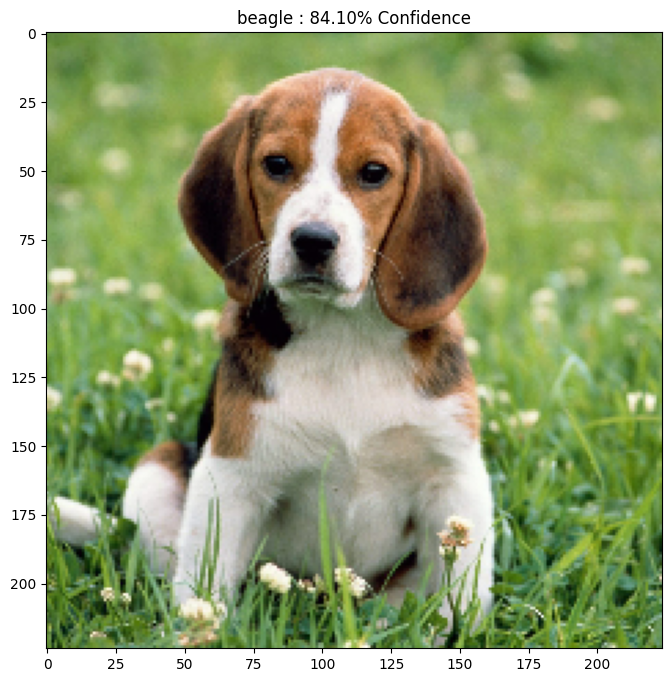

In [ ]:
# Display the image along with its predicted label
plt.figure()
plt.imshow(image[0] * 0.5 + 0.5)  # To change [-1, 1] to [0,1]
_, image_class, class_confidence = get_imagenet_label(image_probs)
plt.title('{} : {:.2f}% Confidence'.format(image_class, class_confidence*100))
plt.show()

In [ ]:
import requests

# Download the file from the torchvision GitHub
url = "https://raw.githubusercontent.com/anishathalye/imagenet-simple-labels/master/imagenet-simple-labels.json"
labels = requests.get(url).json()

# Function to get the indices and names of all dog classes
def get_dog_indices_and_names():
    dog_indices_and_names = [(i, label) for i, label in enumerate(labels) if "Beagle" in label]
    return dog_indices_and_names

# Get the indices and names of all dog classes
dog_indices_and_names = get_dog_indices_and_names()
for index, name in dog_indices_and_names:
    print(f"The index of the dog class '{name}' in the ImageNet dataset is {index}.")


The index of the dog class 'Beagle' in the ImageNet dataset is 162.


In [ ]:
# Define the loss object
loss_object = tf.keras.losses.CategoricalCrossentropy()

In [ ]:
# Function to create adversarial pattern
def create_adversarial_pattern(input_image, input_label):
  with tf.GradientTape() as tape:
    tape.watch(input_image)  # Start recording the operations
    prediction = pretrained_model(input_image)  # Predict the label of the image
    loss = loss_object(input_label, prediction)  # Compute the loss

  # Get the gradients of the loss w.r.t to the input image.
  gradient = tape.gradient(loss, input_image)
  # Get the sign of the gradients to create the perturbation
  return tf.sign(gradient)

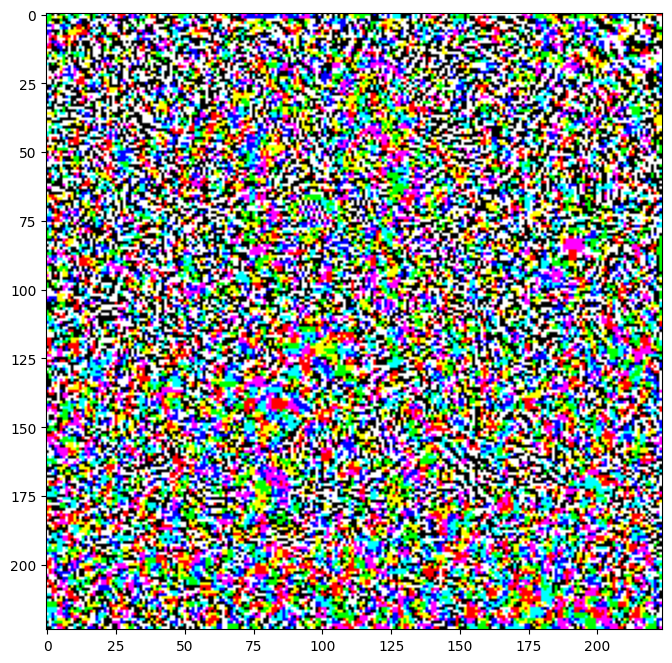

In [ ]:
# Get the input label of the image.
labrador_retriever_index = 162
label = tf.one_hot(labrador_retriever_index, image_probs.shape[-1])
label = tf.reshape(label, (1, image_probs.shape[-1]))

# Create the adversarial patterns
perturbations = create_adversarial_pattern(image, label)
plt.imshow(perturbations[0] * 0.5 + 0.5);  # To change [-1, 1] to [0,1]

In [ ]:
# Function to display images
def display_images(images, descriptions):
  fig, axes = plt.subplots(3, 3, figsize=(20,20))
  axes = axes.flatten()
  for img, desc, ax in zip(images, descriptions, axes):
    _, label, confidence = get_imagenet_label(pretrained_model.predict(img))
    ax.imshow(img[0]*0.5+0.5)
    ax.set_title('{} \n {} : {:.2f}% Confidence'.format(desc, label, confidence*100))
  plt.tight_layout()
  plt.show()

In [ ]:
# List of epsilons
epsilons = [-0.4, -0.15, -0.1, -0.01, 0, 0.01, 0.1, 0.15, 0.4]
# List of descriptions for each epsilon
descriptions = [('Epsilon = {:0.3f}'.format(eps) if eps else 'Input') for eps in epsilons]
# Create a list to hold the adversarial images
adv_images = []

1/1 [==============================] - 0s 51ms/step


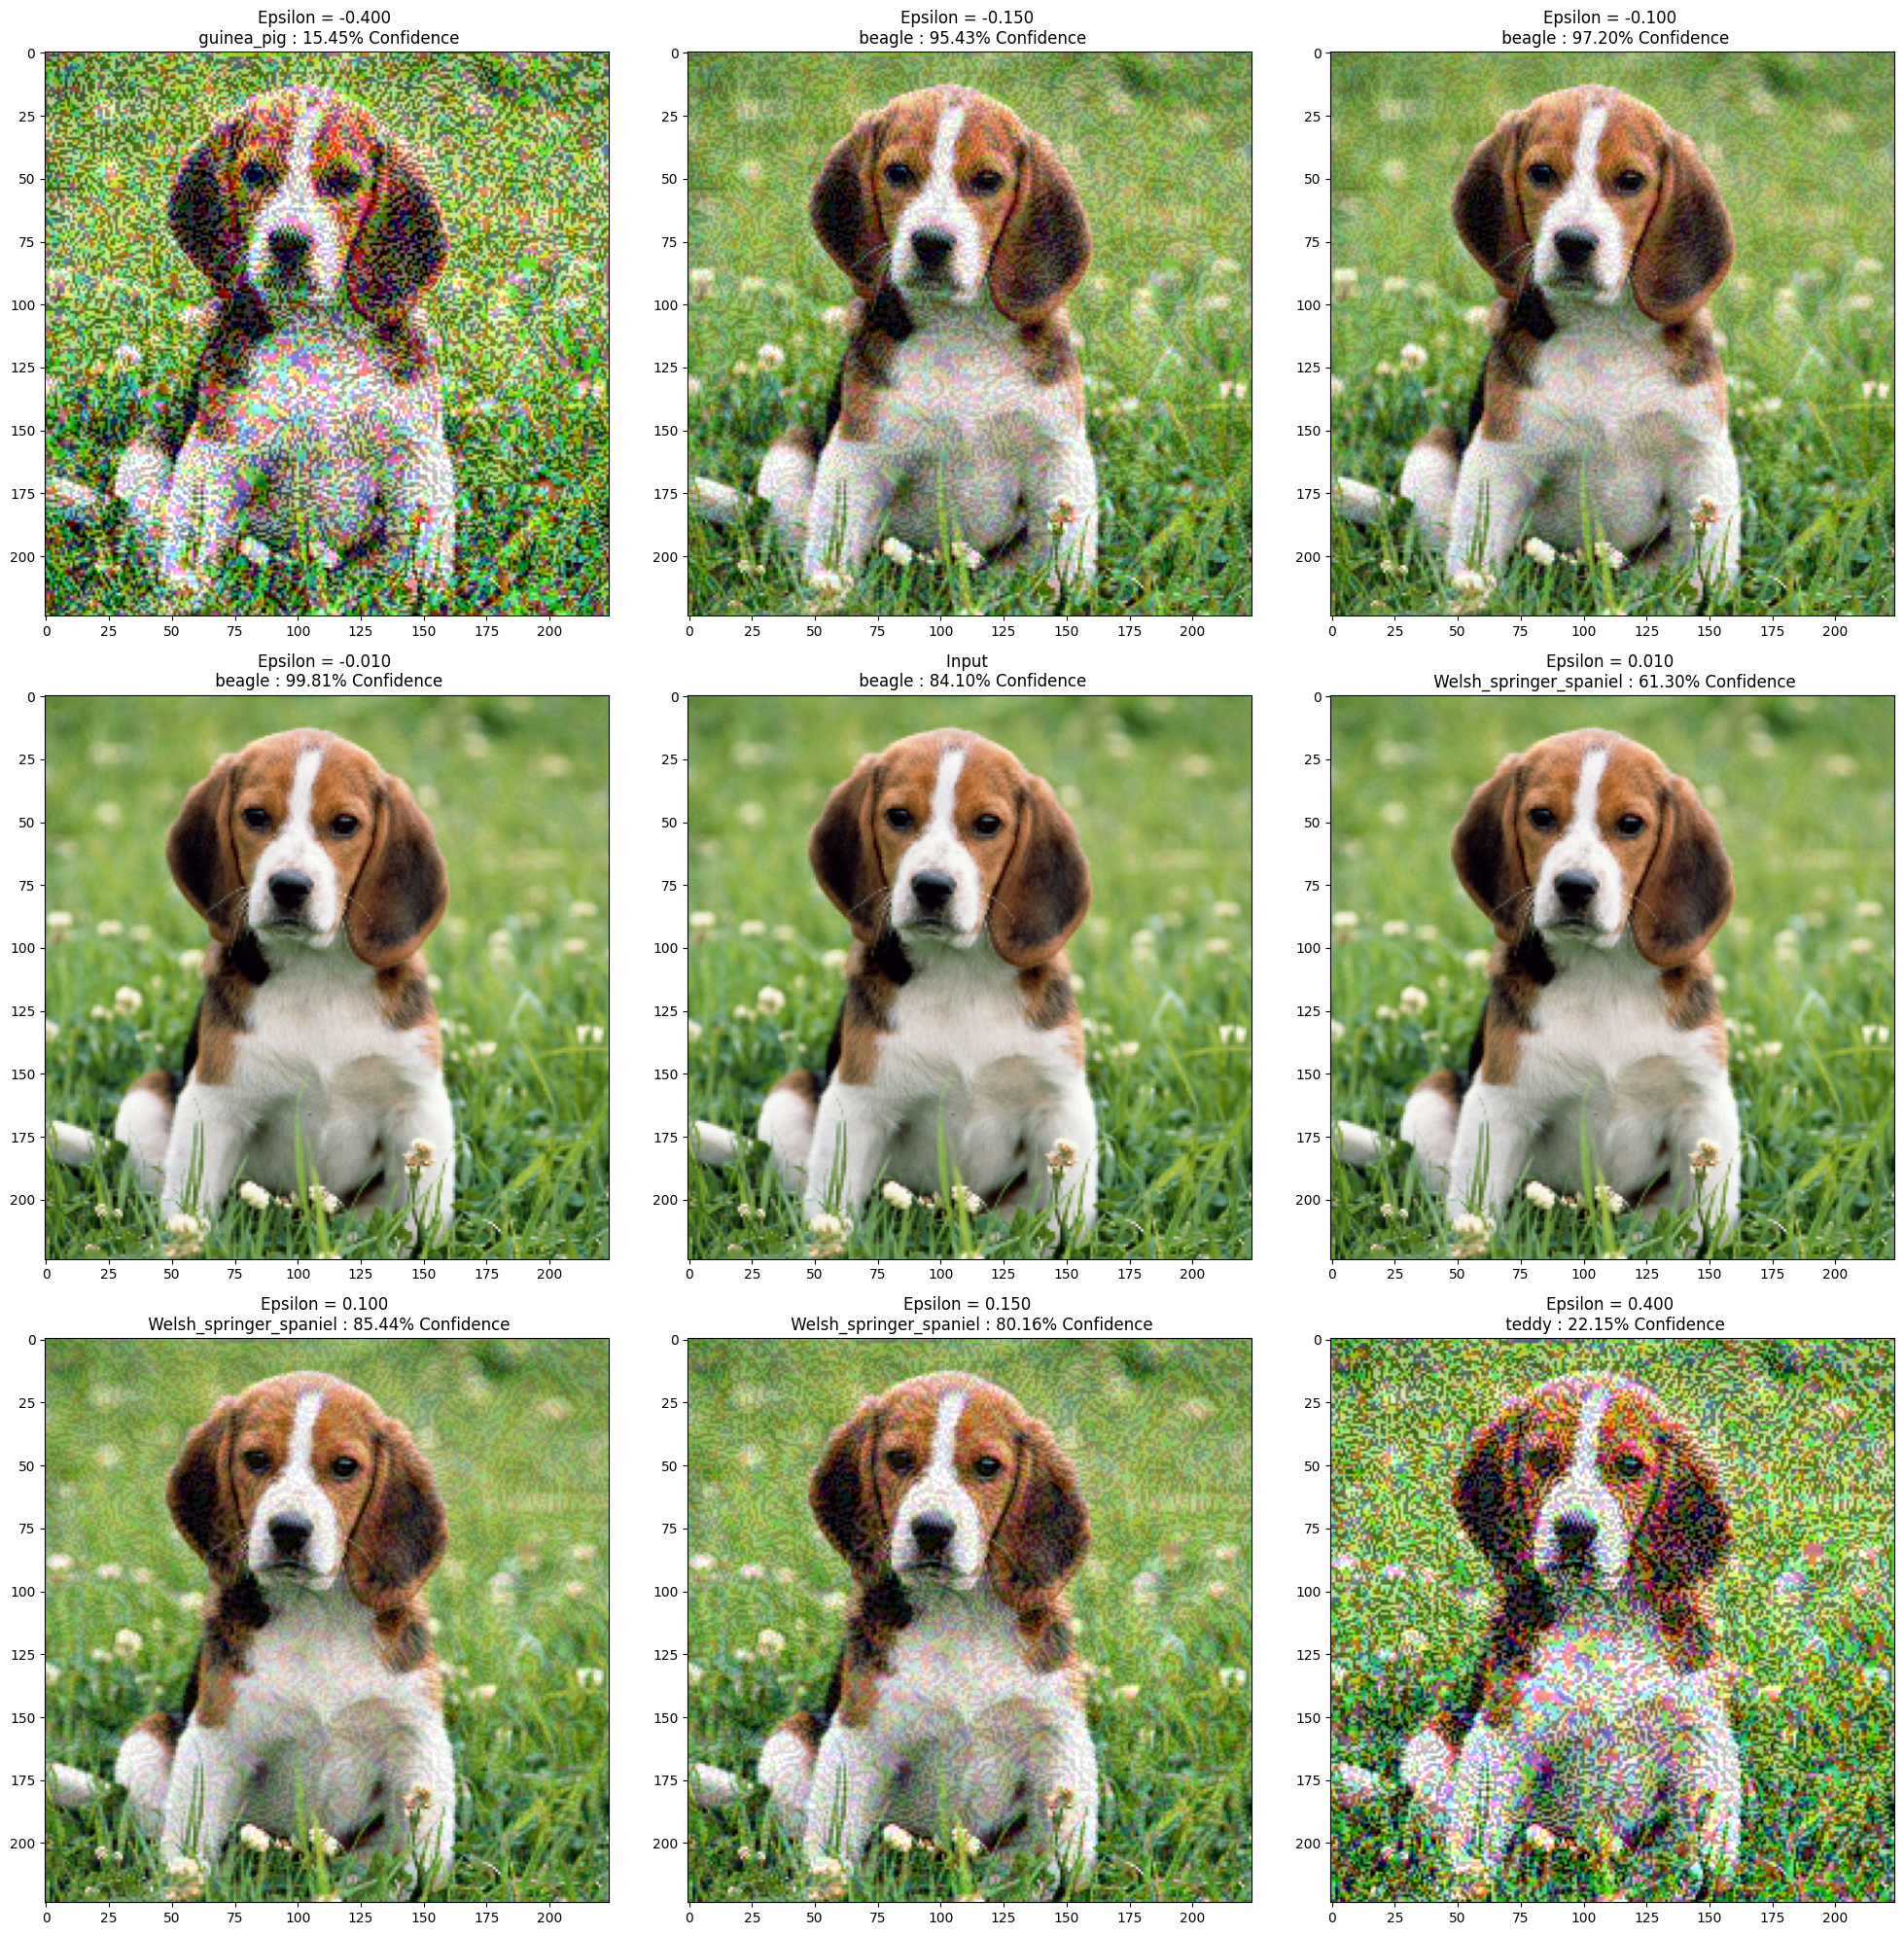

In [ ]:
# For each epsilon, create an adversarial image and add it to the list
for i, eps in enumerate(epsilons):
  adv_x = image + eps*perturbations  # Add the perturbation to the original image
  adv_x = tf.clip_by_value(adv_x, -1, 1)  # Clip the pixel values of the image to be between -1 and 1
  adv_images.append(adv_x)

# Convert the list of adversarial images to a numpy array
adv_images = np.array(adv_images)

# Display the adversarial images
display_images(adv_images, descriptions)